In [1]:
import sys
sys.path.insert(0,"..")
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch, gc
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim

import unet.utils
from unet.model import UNet 
from unet.training import Trainer as UNet_trainer
from gan.discriminator import Discriminator
from mwcnn.mwcnn import MWCNN
from mwcnn.training import Trainer as mwcnn_trainer
from src.loss_functions import FFTloss, VGGPerceptualLoss
from src.dataset import ImageDataset
from src.utils import get_indices

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset part used for testing
TEST_SPLIT = 0.15
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 5
# Dataset folder used
DATASET_USED = 'e9_5_GLM87a_cycle1_8_8'
#DATASET_USED = 'e12_5_slide7_round1_section1'
# Full Dataset path
DATASETS = ['train', 'val']
ROOTDIR = '../data/'

# Training Epochs
EPOCHS = 50

IMAGESIZE=256

gc.collect()
torch.cuda.empty_cache()

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

In [2]:
image_dataset = ImageDataset(ROOTDIR, DATASETS, normalize="percentile", image_size=IMAGESIZE)

train_indices,validation_indices, test_indices = get_indices(len(image_dataset), image_dataset.root_dir, TEST_SPLIT, new=True)
train_sampler,validation_sampler, test_sampler = SubsetRandomSampler(train_indices),SubsetRandomSampler(validation_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(image_dataset, BATCH_SIZE, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(image_dataset, BATCH_SIZE, sampler=validation_sampler)

testloader = torch.utils.data.DataLoader(image_dataset, 1, sampler=test_sampler)

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## Pretrain UNET
First pretrain a UNET and MWCNN, afterwards, this can be used in the GAN set-up

In [5]:
def plot_loss(num_epochs,train_losses):
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
filter_num = [16,32,64,128,256]
unet_model = UNet(filter_num).to(device)
# Training
unet_trainer = UNet_trainer(unet_model,device)
unet_loss_record, validation_loss_record = unet_trainer.train(EPOCHS,trainloader,validationloader,mini_batch=100)

MODEL_NAME = f"../models/UNet-{filter_num}.pth"
torch.save(unet_model, MODEL_NAME)

print(f'Training finished!')

Starting Training Process
Epoch: 001,  
 Training Loss:0.0162955,  
  Validation Loss:0.0131542,  
  Epoch: 002,  
 Training Loss:0.0129399,  
  Validation Loss:0.0131341,  
  Epoch: 003,  
 Training Loss:0.0142881,  
  Validation Loss:0.0158599,  
  Epoch: 004,  
 Training Loss:0.0130022,  
  Validation Loss:0.0128167,  
  Epoch: 005,  
 Training Loss:0.0126154,  
  Validation Loss:0.0140446,  
  Epoch: 006,  
 Training Loss:0.0116161,  
  Validation Loss:0.0117896,  
  Epoch: 007,  
 Training Loss:0.0120275,  
  Validation Loss:0.0112530,  
  Epoch: 008,  
 Training Loss:0.0109895,  
  Validation Loss:0.0109044,  
  Epoch: 009,  
 Training Loss:0.0112260,  
  Validation Loss:0.0106451,  
  Epoch: 010,  
 Training Loss:0.0108434,  
  Validation Loss:0.0164826,  
  Epoch: 011,  
 Training Loss:0.0101965,  
  Validation Loss:0.0094412,  
  Epoch: 012,  
 Training Loss:0.0109113,  
  Validation Loss:0.0100545,  
  Epoch: 013,  
 Training Loss:0.0092457,  
  Validation Loss:0.0085608,  
 

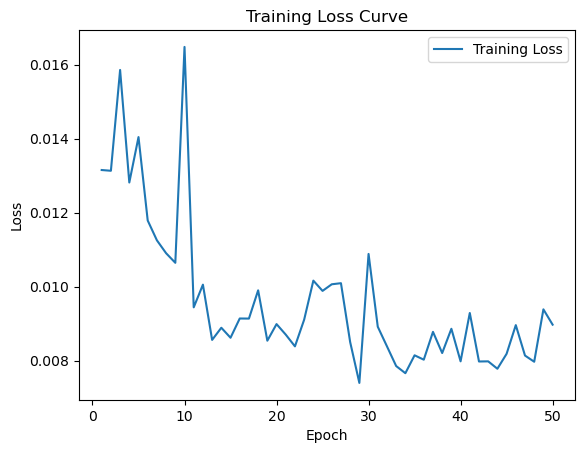

In [26]:
plot_loss(EPOCHS,validation_loss_record)

In [3]:
# Create model
local_criterion = torch.nn.L1Loss()
global_criterion = FFTloss(device, han_window=True)
MWCNN_model = MWCNN(n_feats=64, n_colors=1, batch_normalize=False).to(device)

# Training
MWCNN_trainer = mwcnn_trainer(MWCNN_model, local_criterion, global_criterion, device, clear_cache=True)
mwcnn_loss_record = MWCNN_trainer.train(EPOCHS,trainloader,mini_batch=100)
# torch.save(unet_model, MODEL_NAME)

Starting Training Process
Epoch: 001,  Loss:0.9833180,  
Epoch: 010,  Loss:0.3991740,  
Epoch: 020,  Loss:0.3182878,  
Epoch: 030,  Loss:0.3209365,  
Epoch: 040,  Loss:0.3117183,  
Epoch: 050,  Loss:0.3110160,  


NameError: name 'unet_model' is not defined

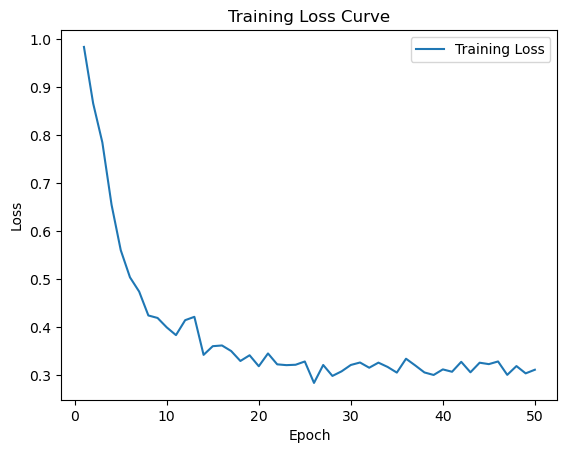

In [6]:
plot_loss(EPOCHS,mwcnn_loss_record)

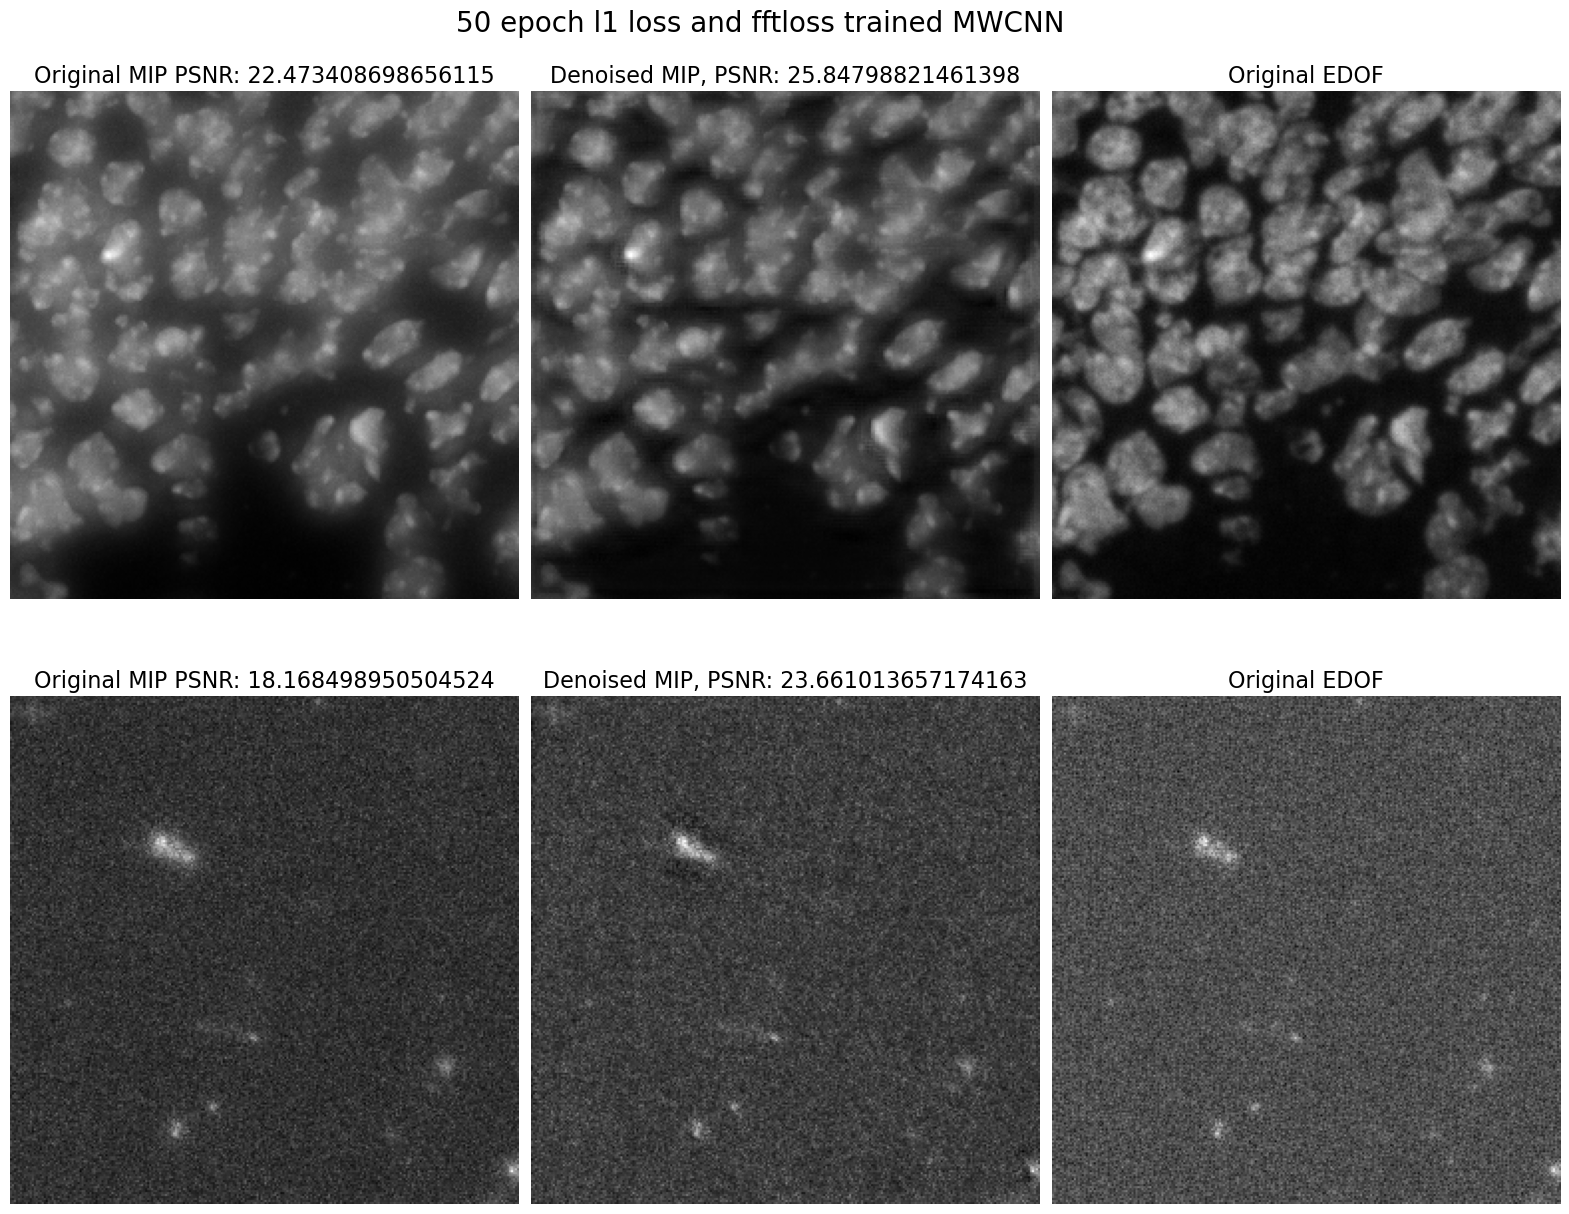

In [9]:
num_pred = 2
results = []
for i in range(num_pred):
    image_index = test_indices[i]
    sample = image_dataset[image_index]
    mip, pred, edof, original_score, improved_score = MWCNN_trainer.predict(sample)
    results.append({
        "MIP": mip,
        "pred": pred,
        "EDOF": edof,
        "original_score": original_score,
        "improved_score": improved_score
    })

from src.utils import plot_result
# plot results
plot_result(results, "50 epoch l1 loss and fftloss trained MWCNN")

In [5]:
# make gan and train
gc.collect()
torch.cuda.empty_cache()

In [6]:
# UNET GAN
generator = unet_model
discriminator = Discriminator(n_feats=64, patch_size=IMAGESIZE).to(device)
discriminator.train()

d_optim = optim.Adam(discriminator.parameters(), lr = 1e-4)
g_optim = optim.Adam(generator.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.StepLR(g_optim, step_size = 2000, gamma = 0.1)

VGG_loss = VGGPerceptualLoss(resize=False).to(device)
cross_ent = torch.nn.BCELoss()
L1_loss_func = torch.nn.L1Loss()

for epoch in range(EPOCHS):
    
    for i, data in enumerate(trainloader):
        # Loading data to device used.
        noisy = data['input_image'].to(device)
        sharp = data['output_image'].float().to(device)
                    
        ## Training Discriminator
        output = generator(noisy)
        real_prob = discriminator(sharp)
        fake_prob = discriminator(output)
        
        real_label = torch.ones_like(real_prob).to(device)
        fake_label = torch.zeros_like(fake_prob).to(device)

        d_loss_real = cross_ent(real_prob, real_label)
        d_loss_fake = cross_ent(fake_prob, fake_label)
        
        d_loss = d_loss_real + d_loss_fake

        g_optim.zero_grad()
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        
        ## Training Generator
        output = generator(noisy)
        fake_prob = discriminator(output)
        
        percep_loss = VGG_loss((sharp + 1.0) / 2.0, (output + 1.0) / 2.0)
        L1_loss = L1_loss_func(output, sharp)
        adversarial_loss = cross_ent(fake_prob, real_label)
        
        g_loss = percep_loss + adversarial_loss + L1_loss
        
        g_optim.zero_grad()
        d_optim.zero_grad()
        g_loss.backward()
        g_optim.step()

        scheduler.step()

    # empty cache after each epoch
    gc.collect()
    torch.cuda.empty_cache()
        
    if epoch % 2 == 0:
        print(epoch)
        print(g_loss.item())
        print(d_loss.item())
        print('=========')


MODEL_NAME = f"../models/UNet-{filter_num}_GAN_trained.pth"
torch.save(generator, MODEL_NAME)

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
2.202456474304199
1.4674124717712402
2
1.9916958808898926
1.3604583740234375
4
1.3336137533187866
1.4415454864501953
6
1.4220523834228516
1.4546942710876465
8
1.9375014305114746
1.2474250793457031
10
2.4857537746429443
2.2316088676452637
12
2.706958770751953
2.163740634918213
14
2.653411388397217
0.3609074056148529
16
1.4615659713745117
0.795422375202179
18
3.4053637981414795
1.5232231616973877
20
1.6591122150421143
1.1979955434799194
22
3.223039388656616
0.6874293684959412
24
4.011760711669922
1.6593575477600098
26
2.503187417984009
0.17962083220481873
28
6.11837911605835
4.674339771270752
30
10.245964050292969
0.016602100804448128
32
3.124681234359741
0.015183687210083008
34
5.773101806640625
0.00840118806809187
36
4.736386775970459
0.4029482305049896
38
9.34800910949707
0.002445041202008724
40
3.1158392429351807
0.17713508009910583
42
8.980387687683105
0.573156476020813
44
10.788345336914062
0.006123641040176153
46
8.887137413024902
0.11604472994804382
48
7.488492012023926
0.04815

In [7]:
def psnr(predicted, target):
    """
    Predicted: the prediction from the model.
    Target: the groud truth.
    """
    mse = np.mean((predicted - target) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1   # minmaxed
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

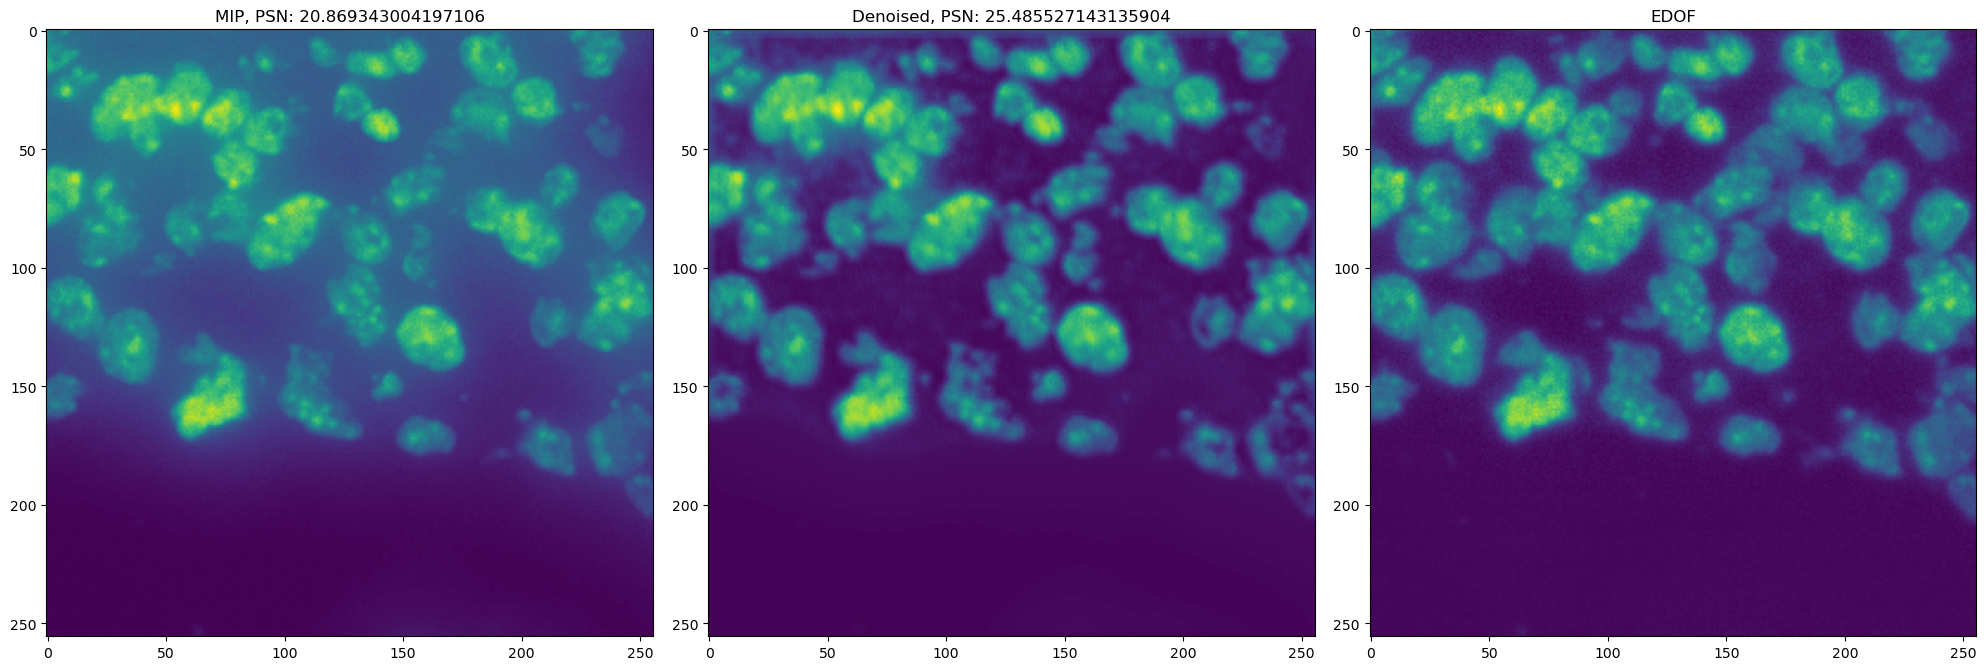

In [25]:
# show results
generator.eval()

for data in testloader:
    noisy = data['input_image'].to(device)
    sharp = data['output_image'].cpu().numpy().squeeze()
    output = generator(noisy)
    output = output.cpu().detach().numpy().squeeze()
    #output = (output + 1.0) / 2.0
    noisy = noisy.cpu().detach().numpy().squeeze()

    output_psnr = psnr(output, sharp)
    nosiy_psnr = psnr(noisy, sharp)
    break

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 60))
image_index = 0
sample = image_dataset[image_index]

ax[0].imshow(noisy.squeeze(), aspect='equal')
ax[0].set_title(f"MIP, PSN: {nosiy_psnr}")
ax[1].imshow(output.squeeze(), aspect='equal')
ax[1].set_title(f"Denoised, PSN: {output_psnr}")
ax[2].imshow(sharp.squeeze(), aspect='equal')
ax[2].set_title(f"EDOF")

plt.tight_layout()
plt.show()

In [10]:
# MWCNN GAN
mwcnn_generator = MWCNN_model
discriminator = Discriminator(n_feats=64, patch_size=IMAGESIZE).to(device)
discriminator.train()

d_optim = optim.Adam(discriminator.parameters(), lr = 1e-4)
g_optim = optim.Adam(mwcnn_generator.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.StepLR(g_optim, step_size = 2000, gamma = 0.1)

VGG_loss = VGGPerceptualLoss(resize=False).to(device)
cross_ent = torch.nn.BCELoss()
L1_loss_func = torch.nn.L1Loss()

for epoch in range(EPOCHS):
    
    for i, data in enumerate(trainloader):
        # Loading data to device used.
        noisy = data['input_image'].to(device)
        sharp = data['output_image'].float().to(device)
                    
        ## Training Discriminator
        output = mwcnn_generator(noisy)
        real_prob = discriminator(sharp)
        fake_prob = discriminator(output)
        
        real_label = torch.ones_like(real_prob).to(device)
        fake_label = torch.zeros_like(fake_prob).to(device)

        d_loss_real = cross_ent(real_prob, real_label)
        d_loss_fake = cross_ent(fake_prob, fake_label)
        
        d_loss = d_loss_real + d_loss_fake

        g_optim.zero_grad()
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        
        ## Training Generator
        output = mwcnn_generator(noisy)
        fake_prob = discriminator(output)
        
        percep_loss = VGG_loss((sharp + 1.0) / 2.0, (output + 1.0) / 2.0)
        L1_loss = L1_loss_func(output, sharp)
        adversarial_loss = cross_ent(fake_prob, real_label)
        
        g_loss = percep_loss + adversarial_loss + L1_loss
        
        g_optim.zero_grad()
        d_optim.zero_grad()
        g_loss.backward()
        g_optim.step()

        scheduler.step()

    # empty cache after each epoch
    gc.collect()
    torch.cuda.empty_cache()
        
    if epoch % 2 == 0:
        print(epoch)
        print(g_loss.item())
        print(d_loss.item())
        print('=========')


MODEL_NAME = f"../models/MWCNN_GAN_trained.pth"
torch.save(mwcnn_generator, MODEL_NAME)

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
0.5855355858802795
100.0
2
0.444813996553421
100.0
4
0.6631684899330139
100.0
6
1.0304878950119019
100.0


In [ ]:
# show results
mwcnn_generator.eval()

for data in testloader:
    noisy = data['input_image'].to(device)
    sharp = data['output_image'].cpu().numpy().squeeze()
    output = mwcnn_generator(noisy)
    output = output.cpu().detach().numpy().squeeze()
    #output = (output + 1.0) / 2.0
    noisy = noisy.cpu().detach().numpy().squeeze()

    output_psnr = psnr(output, sharp)
    nosiy_psnr = psnr(noisy, sharp)
    break

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 60))
image_index = 0
sample = image_dataset[image_index]

ax[0].imshow(noisy.squeeze(), aspect='equal')
ax[0].set_title(f"MIP, PSN: {nosiy_psnr}")
ax[1].imshow(output.squeeze(), aspect='equal')
ax[1].set_title(f"Denoised, PSN: {output_psnr}")
ax[2].imshow(sharp.squeeze(), aspect='equal')
ax[2].set_title(f"EDOF")

plt.tight_layout()
plt.show()